# Capstone Project - The Battle of Neighbourhoods

## Business Problem

In this project, we are trying to address the business problem, "Which neighbourhood in Toronto is suitable to open a specific type of restaurant, in this case a Chinese Restaurant?" We're looking for a neighbourhood where Chinese Restaurants are less.

This project is particularly helpful for the entrepreneurs who are looking to open an Chinese restaurant in Toronto. It also helps food lovers to find a neighbourhood with most number of Chinese restaurants.

## Data Collection

### Neighbourhood Data

The list of Boroughs and Neighbourhoods of Toronto is obtained from wikipedia using web scraping techniques. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [18]:
import pandas as pd
import numpy as np
import requests

In [3]:
!pip install wikipedia
import wikipedia as wp

  Stored in directory: /home/dsxuser/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [4]:
webpage = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df = pd.read_html(webpage, header=0)[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
df['Neighbourhood'] = np.where(df.Neighbourhood == 'Not assigned', df.Borough, df.Neighbourhood)
df['Neighbourhood'] = df['Neighbourhood'].replace('Not assigned',np.nan)
df['Borough'] = df['Borough'].replace('Not assigned',np.nan)
df = df.dropna(axis=0, how='any', thresh=None, subset=None)
df = df.reset_index()
del df['index']
df  = df.groupby(['Postcode', 'Borough']).agg({'Neighbourhood': lambda x: ','.join(tuple(x.tolist()))})
df = df.reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Geographical Coordinates Data

In [6]:
!wget -O load_coordinates.csv http://cocl.us/Geospatial_data

--2020-02-26 14:30:18--  http://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 158.85.108.86, 158.85.108.83, 169.48.113.194
Connecting to cocl.us (cocl.us)|158.85.108.86|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cocl.us/Geospatial_data [following]
--2020-02-26 14:30:19--  https://cocl.us/Geospatial_data
Connecting to cocl.us (cocl.us)|158.85.108.86|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-26 14:30:21--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.24.197, 107.152.27.197, 107.152.25.197, ...
Connecting to ibm.box.com (ibm.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-26 1

In [7]:
df_coord = pd.read_csv('load_coordinates.csv')
df_coord.columns = ['Postcode','Latitude','Longitude']
df_final = pd.merge(df, df_coord, on='Postcode')
df_final = df_final.drop_duplicates()
df_final.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [8]:
print('Number of Broughs in the dataset: {} '.format(len(df_final['Borough'].unique())))
print('Number of Neighbourhoods in the dataset: {} '.format(len(df_final['Neighbourhood'].unique())))

Number of Broughs in the dataset: 10 
Number of Neighbourhoods in the dataset: 103 


### Get Geocoordinates of Toronto using GeoPy

In [14]:
!pip install geopy
from geopy.geocoders import Nominatim

In [26]:
import json
from pandas.io.json import json_normalize

In [16]:
city = 'Toronto'
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print("Latitude = {}, Longitude = {} ".format(latitude, longitude))

Latitude = 43.653963, Longitude = -79.387207 


### Get Venues in Toronto from FourSquare

In [17]:
# The code was removed by Watson Studio for sharing.

In [19]:
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
results = requests.get(url).json()

In [25]:
def get_categories(row):
    try:
        categories = row['categories']
    except:
        categories = row['venue.categories']

    if len(categories) == 0:
        return None
    else:
        return categories[0]['name']

In [27]:
column_list = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
items = results['response']['groups'][0]['items']

venues = json_normalize(items) 
venues =venues.loc[:, column_list]
venues['venue.categories'] = venues.apply(get_categories, axis=1)
venues.columns = [col.split(".")[-1] for col in venues.columns]
venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Karine's,Breakfast Spot,43.653699,-79.390743
3,Manpuku まんぷく,Japanese Restaurant,43.653612,-79.390613
4,Nathan Phillips Square,Plaza,43.652270,-79.383516


In [31]:
def getNeighbourVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    neighbour_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    neighbour_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(neighbour_venues)

In [32]:
LIMIT = 100
toronto_venues = getNeighbourVenues(names=df_final['Neighbourhood'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [33]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [38]:
toronto_venues[toronto_venues['Venue Category']=='Chinese Restaurant']

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
47,"Dorset Park,Scarborough Town Centre,Wexford He...",43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
68,"Clarks Corners,Sullivan,Tam O'Shanter",43.781638,-79.304302,The Royal Chinese Restaurant 避風塘小炒,43.780505,-79.298844,Chinese Restaurant
82,L'Amoreaux West,43.799525,-79.318389,Mr Congee Chinese Cuisine 龍粥記,43.798879,-79.318335,Chinese Restaurant
83,L'Amoreaux West,43.799525,-79.318389,Phoenix Restaurant 金鳳餐廳,43.798198,-79.318432,Chinese Restaurant
158,"Fairview,Henry Farm,Oriole",43.778517,-79.346556,Manchu Wok,43.778225,-79.343302,Chinese Restaurant
165,Bayview Village,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
236,"Flemingdon Park,Don Mills South",43.725900,-79.340923,Congee Star 帝王名粥,43.726586,-79.341833,Chinese Restaurant
484,North Toronto West,43.715383,-79.405678,C'est Bon,43.716785,-79.400406,Chinese Restaurant
597,"Cabbagetown,St. James Town",43.667967,-79.367675,China Gourmet,43.664180,-79.368359,Chinese Restaurant
598,"Cabbagetown,St. James Town",43.667967,-79.367675,Tender Trap Restaurant,43.667724,-79.369485,Chinese Restaurant


## Data Analysis

In [39]:
!pip install folium
import folium

     |████████████████████████████████| 92kB 4.4MB/s eta 0:00:011


### Plot Neighbourhoods on Map

In [40]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighbourhood in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Neighbourhood']):
    label = '{},{}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [48]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']
cols = toronto_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.reindex(columns= cols)

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.1,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


In [49]:
toronto_subset = toronto_grouped[['Neighbourhood', 'Chinese Restaurant']]
toronto_subset

,Neighbourhood,Chinese Restaurant
0,"Adelaide,King,Richmond",0.000000
1,Agincourt,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000
4,"Alderwood,Long Branch",0.000000
5,"Bathurst Manor,Downsview North,Wilson Heights",0.000000
6,Bayview Village,0.250000
7,"Bedford Park,Lawrence Manor East",0.000000
8,Berczy Park,0.000000
9,"Birch Cliff,Cliffside West",0.000000


In [50]:
toronto_merged = pd.merge(df_final, toronto_subset, on='Neighbourhood')
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Chinese Restaurant
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0.000000
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0.000000
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.000000
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.000000
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.000000
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0.000000
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,0.000000
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,0.000000
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,0.000000
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.000000


### Neighbourhoods with Chinese Restaurants

In [51]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt 

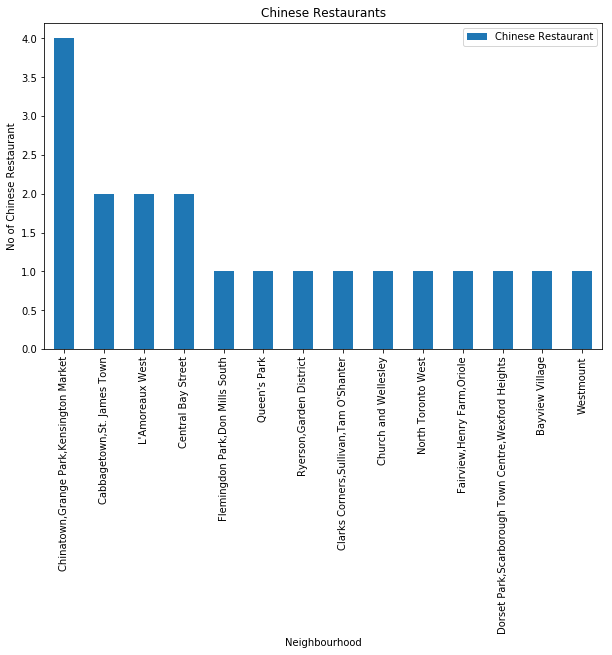

In [55]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighbourhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by ='Chinese Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighbourhood")
plt.ylabel("No of Chinese Restaurants")
plt.title("Chinese Restaurants")
plt.show()